# Extending `hazma` to $m_{\chi}\sim \mathrm{GeV}$

In this notebook, we will be developing a vector mediator model in `hazma` which allows us to use DM masses up to a GeV. We will be using the work performed by Peter and friends where they extracted form factors to various final states.

Form factor TODO list:
- DONE $V_{\mu}\pi^{+}\pi^{-}$
- DONE $V_{\mu}\pi^0\gamma$
- TODO $V_{\mu}\pi\omega$
- TODO $V_{\mu}\pi\Phi$
- TODO $V_{\mu}\eta\gamma$
- TODO $V_{\mu}\eta\omega$
- TODO $V_{\mu}\eta\Phi$
- TODO $V_{\mu}KK$


In [ ]:
Hans Kuhn

In [2]:
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
import matplotlib

from hazma.vector_mediator import VectorMediator, KineticMixing
from hazma.parameters import (
    neutral_pion_mass as mpi0,
    charged_pion_mass as mpi,
    Qu, Qd, Qe, qe
)

from form_factors import F2pi, alpha, Resonance
from form_factors.Resonance import MeV

## Classes for computing meson-vector mediator form factors

In [3]:
class FormFactorPiPi:
    """
    Class for computing the pi-pi-vector form-factor.
    """
    
    def __init__(self, ci0, ci1):
        
        self._ci0 = ci0
        self._ci1 = ci1
        self._mpi = 0.13957018
        
        # truncation parameter
        self._n_max = 2000
        # omega parameters, relevant for the rho-omega mixing in the 0th order rho resonance
        self._omega_mag = 0.00187
        self._omega_phase = 0.106
        self._omega_mass = 0.7824
        self._omega_width = 0.00833
        self._omega_wgt = 0.0
        self._beta = 2.148
        # rho parameters, for 0th to 5th order rho resonances
        self._rho_mag = [1.0, 1.0, 0.59, 4.8e-2, 0.40, 0.43]
        self._rho_phase = [0.0, 0.0, -2.2, -2.0, -2.9, 1.19]
        self._rho_mass = [0.77337, 1.490, 1.870, 2.12, 2.321, 2.567]
        self._rho_width = [0.1471, 0.429, 0.357, 0.3, 0.444, 0.491]
        self._rho_wgt = []
        
        self._mass = []
        self._width = []
        self._coup = []
        self._hres = []
        self._h0 = []
        self._dh = []
        
        self._initialize()

        
    @property
    def ci0(self):
        return self._ci0
    
    @ci0.setter
    def ci0(self, val):
        self._ci0 = val
    
    @property
    def ci1(self):
        return self._ci1
    
    @property
    def ci1(self, val):
        self._ci1 = val
        self._initialize()
        
        
    # initialize tower of couplings
    def _initialize(self):
        rho_sum = 0.0
        # print self._rho_wgt
        for ix in range(0, len(self._rho_mag)):
            self._rho_wgt.append(
                self._rho_mag[ix]
                * (
                    np.cos(self._rho_phase[ix])
                    + complex(0.0, 1.0) * np.sin(self._rho_phase[ix])
                )
            )
            if ix > 0:
                rho_sum += self._rho_wgt[ix]
        self._omega_wgt = self._omega_mag * (
            np.cos(self._omega_phase) + complex(0.0, 1.0) * np.sin(self._omega_phase)
        )
        # set up the masses and widths of the rho resonances
        gam_b = gamma(2.0 - self._beta)
        cwgt = 0.0
        for ix in range(self._n_max):
            # this is gam(2-beta+n)/gam(n+1)
            if ix > 0:
                gam_b *= ((1.0 - self._beta + float(ix))) / float(ix)
            c_n = (
                gamma(self._beta - 0.5)
                / (0.5 + float(ix))
                / np.sqrt(np.pi)
                * np.sin(np.pi * (self._beta - 1.0 - float(ix)))
                / np.pi
                * gam_b
            )
            if ix % 2 != 0:
                c_n *= -1.0
            if ix == 0:
                # print 'testing 0',c_n,1.087633403691967
                c_n = 1.087633403691967
            # set the masses and widths
            # calc for higher resonances
            if ix >= len(self._rho_mass):
                self._mass.append(self._rho_mass[0] * np.sqrt(1.0 + 2.0 * float(ix)))
                self._width.append(self._rho_width[0] / self._rho_mass[0] * self._mass[-1])
            # input for lower ones
            else:
                self._mass.append(self._rho_mass[ix])
                self._width.append(self._rho_width[ix])
            if ix > 0 and ix < len(self._rho_wgt):
                cwgt += c_n
            # parameters for the gs propagators
            self._hres.append(Resonance.Hhat(self._mass[-1] ** 2, self._mass[-1], self._width[-1], self._mpi, self._mpi))
            self._dh.append(Resonance.dHhatds(self._mass[-1], self._width[-1], self._mpi, self._mpi))
            self._h0.append(
                Resonance.H(0.0, self._mass[-1], self._width[-1], self._mpi, self._mpi, self._dh[-1], self._hres[-1])
            )
            self._coup.append(self._ci1 * c_n)
        # fix up the early weights
        for ix in range(1, len(self._rho_wgt)):
            # print ix
            self._coup[ix] = self._ci1 * self._rho_wgt[ix] * cwgt / rho_sum
            
    def __call__(self, q2, imode):
        ff = complex(0.0, 0.0)
        # print coup_[0]
        for ix in range(self._n_max):
            term = self._coup[ix] * Resonance.BreitWignerGS(
                q2, self._mass[ix], self._width[ix], self._mpi, self._mpi, self._h0[ix], self._dh[ix], self._hres[ix]
            )
            # include rho-omega if needed
            if ix == 0 and imode != 0:
                term *= (
                    1.0
                    / (1.0 + self._omega_wgt)
                    * (
                        1.0
                        + self._omega_wgt * Resonance.BreitWignerFW(q2, self._omega_mass, self._omega_width)
                    )
                )
            # sum
            ff += term
        # factor for cc mode
        if imode == 0:
            ff *= np.sqrt(2.0)
        return ff
        

In [4]:
class FormFactorPiGamma:
    def __init__(self, gvuu, gvdd, gvss):
        
        self._ci0 = 3.0 * (gvuu + gvdd)
        self._ci1 = gvuu - gvdd
        self._cs = -3.0 * gvss
        
        self._res_masses = [0.77526, 0.78284, 1.01952, 1.45, 1.70]
        self._res_widths = [0.1491, 0.00868, 0.00421, 0.40, 0.30]
        self._amp = [0.0426, 0.0434, 0.00303, 0.00523, 0.0]
        self._phase = [-12.7, 0.0, 158.0, 180.0, 0.0]
        self._mpi = 0.13957061

        self._c_rho = 1.0
        self._c_omega = 1.0
        self._c_phi = 1.0
        self._c_rho_om_phi = [
            self._ci1, 
            self._ci0, 
            self._cs, 
            self._ci0,
            self._ci0
        ]
        
    def _widths(self, q2, ix):
        Q = np.sqrt(q2)
        if ix==0:
            pcm = 0.5 * (q2 - self._mpi ** 2) / Q
            widths = (
                self._res_widths[0]
                * self._res_masses[0] ** 2 
                / q2
                * (
                    (q2 - 4.0 * self._mpi ** 2) 
                    / (self._res_masses[0] ** 2 - 4.0 * self._mpi ** 2)
                )**1.5
            )
        else:
            widths = self._res_widths[ix]
        return widths
    
    def __call__(self, q2):
        Q = np.sqrt(q2)
        ii = 0.0 + 1.0j
        form = 0.0
        for i in range(0, len(self._res_masses)):
            Di = self._res_masses[i]** 2 - q2 - ii * Q * self._widths(q2, i)
            form += (
                self._c_rho_om_phi[i]
                * self._amp[i] 
                * self._res_masses[i] ** 2 
                * np.exp(ii * np.radians(self._phase[i]))
                / Di
            )
        return form

## Class for extending `VectorMediator` and `KineticMixing` to the GeV

In [5]:
class VectorMediatorGeV(VectorMediator):
    def __init__(self, mx, mv, gvxx, gvuu, gvdd, gvss, gvee, gvmumu):
        
        self._form_factor_pipi_obj = FormFactorPiPi(
            gvuu + gvdd,
            gvuu - gvdd
        )
        self._form_factor_pig_obj = FormFactorPiGamma(gvuu, gvdd, gvss)
        
        super(VectorMediatorGeV, self).__init__(mx, mv, gvxx, gvuu, gvdd, gvss, gvee, gvmumu)
        
    def _reset_state(self):
        """
        Function to reset the state of the derived quantities such as
        the vector width and the form factors.
        """
        self._form_factor_pipi_obj = FormFactorPiPi(
            self._gvuu + self._gvdd,
            self._gvuu - self._gvdd
        )
        self._form_factor_pig_obj = FormFactorPiGamma(
            self._gvuu, 
            self._gvdd, 
            self._gvss
        )
        self.compute_width_v()
    
    def _form_factor_pipi(self, s, imode=1):
        """
        Compute the pi-pi-V form factor for a give squared CME.
        """
        sgev = s * 1e-6 # Convert s to GeV
        return self._form_factor_pipi_obj(sgev, imode)
    
    def _form_factor_pi0g(self, s):
        """
        Compute the pi-pi-V form factor for a give squared CME.
        """
        sgev = s * 1e-6 # Convert s to GeV
        return self._form_factor_pig_obj(sgev)
    
    @property
    def gvuu(self):
        return self._gvuu
    
    @gvuu.setter
    def gvuu(self, gvuu):
        self._gvuu = gvuu
        self._reset_state()
    
    @property
    def gvdd(self):
        return self._gvdd
    
    @gvdd.setter
    def gvdd(self, gvdd):
        self._gvdd = gvdd
        self._reset_state()
        
    def width_v_to_pipi(self):
        """
        Compute the partial width for the decay of a vector mediator
        into two charged pions.
        """
        if self.mv < 2 * mpi:
            return 0.0
        ff = self._form_factor_pipi(self.mv**2)
        return (
            1.0
            / 48.0
            / np.pi
            * self.mv
            * (1 - 4 * mpi ** 2 / self.mv ** 2) ** 1.5
            * abs(ff) ** 2
        )
    
    def width_v_to_pi0g(self):
        """
        Compute the partial width for the decay of a vector mediator
        into a neutral pion and photon.
        """
        if self.mv < mpi:
            return 0.0
        ff = self._form_factor_pi0g(self.mv**2)
        return (
            self.mv
            * abs(ff) ** 2
            * (1.0 - (mpi / self.mv) ** 2) ** 3
            / (6.0 * np.pi)
        )
    
    def sigma_xx_to_v_to_pipi(self, e_cm):
        gamv = self.width_v
        mv = self.mv
        mx = self.mx
        if e_cm < 2.0 * mx or e_cm < 2.0 * mpi:
            return 0.0
        
        s = e_cm**2
        # Compute 
        ff = self._form_factor_pipi(s)
        num = self.gvxx**2 * abs(ff)**2 * (s - 4 * mpi**2)**1.5 * (2.0 * mx**2 + s)
        den = 48.0 * np.pi * s * np.sqrt(s - 4.0 * mx**2) * (mv**2 * (gamv**2 - 2.0 * s) + mv**4 + s**2)

        return num / den
    

class KineticMixingGeV(VectorMediatorGeV):
    """
    Sub-class of the `VectorMediatorGeV` class for the special case of
    kinetic mixing where all the quark and lepton couplings are determined
    from a kinetic mixing term of the form: -eps / 2 * V_{mu, nu} F^{mu, nu}.
    """
    
    def __init__(self, mx, mv, gvxx, eps):
        self._eps = eps
        
        super(KineticMixingGeV, self).__init__(
            mx, 
            mv, 
            gvxx, 
            -Qu * eps * qe,
            -Qd * eps * qe,
            -Qd * eps * qe,
            -Qe * eps * qe,
            -Qe * eps * qe
        )
        
    @property
    def eps(self):
        return self._eps
        
    @eps.setter
    def eps(self, eps):
        self._eps = eps
        self._gvuu = -Qu * eps * qe
        self._gvdd = -Qd * eps * qe
        self._gvss = -Qd * eps * qe
        self._gvee = -Qe * eps * qe
        self._gvmumu = -Qe * eps * qe
        self._reset_state()
   
    @VectorMediatorGeV.gvuu.setter
    def gvuu(self, gvuu):
        raise AttributeError("Cannot set gvuu. It is a derived quantity.")
    
    @VectorMediatorGeV.gvdd.setter
    def gvdd(self, gvdd):
        raise AttributeError("Cannot set gvdd. It is a derived quantity.")
        
    @VectorMediatorGeV.gvss.setter
    def gvss(self, gvss):
        raise AttributeError("Cannot set gvss. It is a derived quantity.")
        
    @VectorMediatorGeV.gvee.setter
    def gvee(self, gvee):
        raise AttributeError("Cannot set gvee. It is a derived quantity.")
    
    @VectorMediatorGeV.gvmumu.setter
    def gvmumu(self, gvmumu):
        raise AttributeError("Cannot set gvmumu. It is a derived quantity.")

In [6]:
mx = 100.0
mv = 1e3
gvxx = 1.0
eps = 1e-3

vmgev_params = {
    'mx': mx, 
    'mv': mv, 
    'gvxx': gvxx, 
    'gvuu': -Qu * eps * qe, 
    'gvdd': -Qd * eps * qe, 
    'gvss': -Qd * eps * qe, 
    'gvee': -Qe * eps * qe, 
    'gvmumu': -Qe * eps * qe
}
kmgev_params = {
    'mx': mx, 
    'mv': mv, 
    'gvxx': gvxx, 
    'eps': eps, 
}

vm = VectorMediatorGeV(**vmgev_params)
vmgev = VectorMediatorGeV(**vmgev_params)
kmgev = KineticMixingGeV(**kmgev_params)

In [7]:
form_factor_two_pion = TwoPionFormFactor(1.0, 1.0)
q2s = np.logspace(-5, 0, 100)
ffs = np.array([form_factor_two_pion(q2, 1) for q2 in q2s])
ffs_re = np.array([abs(ff.real) for ff in ffs])
ffs_im = np.array([abs(ff.imag) for ff in ffs])

NameError: name 'TwoPionFormFactor' is not defined

In [8]:
plt.figure(dpi=100)
plt.plot(q2s, ffs_re)
plt.plot(q2s, ffs_im)
plt.yscale('log')
plt.xscale('log')

NameError: name 'q2s' is not defined

<Figure size 600x400 with 0 Axes>

## Plot of the Widths

In [9]:
params = {'mx': 250.0, 'mv': 1e3, 'gvxx': 0.0, 'eps': 1e-3}
km = KineticMixing(**params)
kmgev = KineticMixingGeV(**params)

mvs = np.linspace(2 * mpi, 5e3, 150)
km_ws = {key: np.zeros_like(mvs) for key in km.partial_widths().keys()}
kmgev_ws = {key: np.zeros_like(mvs) for key in kmgev.partial_widths().keys()}

for i, mv in enumerate(mvs):
    km.mv = mv
    kmgev.mv = mv
    km_w = km.partial_widths()
    kmgev_w = kmgev.partial_widths()
    for key in km_ws.keys():
        km_ws[key][i] = km_w[key]
        kmgev_ws[key][i] = kmgev_w[key]

<ipython-input-4-04cfce06358b>:33: RuntimeWarning: invalid value encountered in double_scalars
  * (
<ipython-input-4-04cfce06358b>:49: RuntimeWarning: invalid value encountered in cdouble_scalars
  self._c_rho_om_phi[i]


In [10]:
km_bfs = {key: km_ws[key] / km_ws['total'] for key in km_ws.keys() if not key == 'total'} 
kmgev_bfs = {key: kmgev_ws[key] / kmgev_ws['total'] for key in kmgev_ws.keys() if not key == 'total'} 

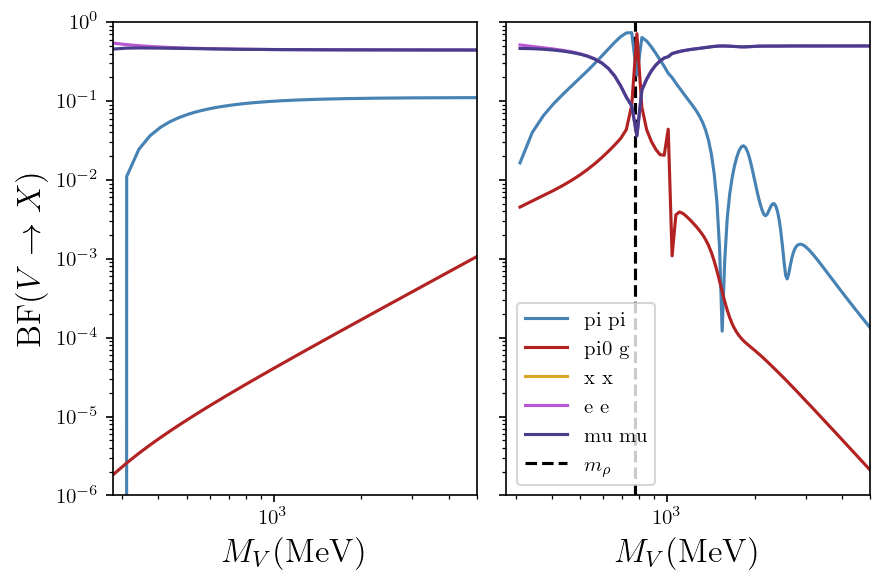

In [14]:
YMIN, YMAX = 1e-6, 1.0

ig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, dpi=150)

for key in km_bfs.keys():
    #if key == 'pi0 g':
    #    continue
    ax1.plot(mvs, km_bfs[key], label=key)
    ax2.plot(mvs, kmgev_bfs[key], label=key)

ax2.vlines(0.77337e3, YMIN, YMAX, ls='--', color='k', label=r'$m_{\rho}$')

ax1.set_xlabel(r'$M_{V} (\mathrm{MeV})$', fontsize=16)
ax2.set_xlabel(r'$M_{V} (\mathrm{MeV})$', fontsize=16)
ax1.set_ylabel(r'$\mathrm{BF}(V\to X)$', fontsize=16)
ax1.set_ylim([YMIN, YMAX])
ax1.set_xlim([np.min(mvs), np.max(mvs)])
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.legend()
plt.tight_layout()
